In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer/Breast_Cancer.csv


In [214]:
import lightgbm
import seaborn as sns
from matplotlib import pyplot as pplot

In [215]:
df = pd.read_csv("/kaggle/input/breast-cancer/Breast_Cancer.csv")

In [216]:
df['Race']

0       White
1       White
2       White
3       White
4       White
        ...  
4019    Other
4020    White
4021    White
4022    Black
4023    White
Name: Race, Length: 4024, dtype: object

In [217]:
df['Status'] = df['Status'].apply(lambda x: 1 if x=='Alive' else 0)

In [218]:
str_cols = df.select_dtypes(include='object').columns.to_list()
n_cols = df.select_dtypes(include='int64').columns.to_list()
n_cols.remove('Status')

In [219]:
string_cols = []
for col in str_cols:
    n_col = col.replace(' ', '_').lower()
    df[n_col] = df[col]
    string_cols.append(n_col)
    
num_cols = []
for col in n_cols:
    n_col = col.replace(' ', '_').lower()
    df[n_col] = df[col]
    num_cols.append(n_col)
    

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4024.0,53.972167,8.963134,30.0,47.0,54.0,61.0,69.0
Tumor Size,4024.0,30.473658,21.119696,1.0,16.0,25.0,38.0,140.0
Regional Node Examined,4024.0,14.357107,8.099675,1.0,9.0,14.0,19.0,61.0
Reginol Node Positive,4024.0,4.158052,5.109331,1.0,1.0,2.0,5.0,46.0
Survival Months,4024.0,71.297962,22.921430,1.0,56.0,73.0,90.0,107.0
Status,4024.0,0.846918,0.360111,0.0,1.0,1.0,1.0,1.0


In [54]:
import plotly.express as px
px.imshow(df[num_cols].corr())

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

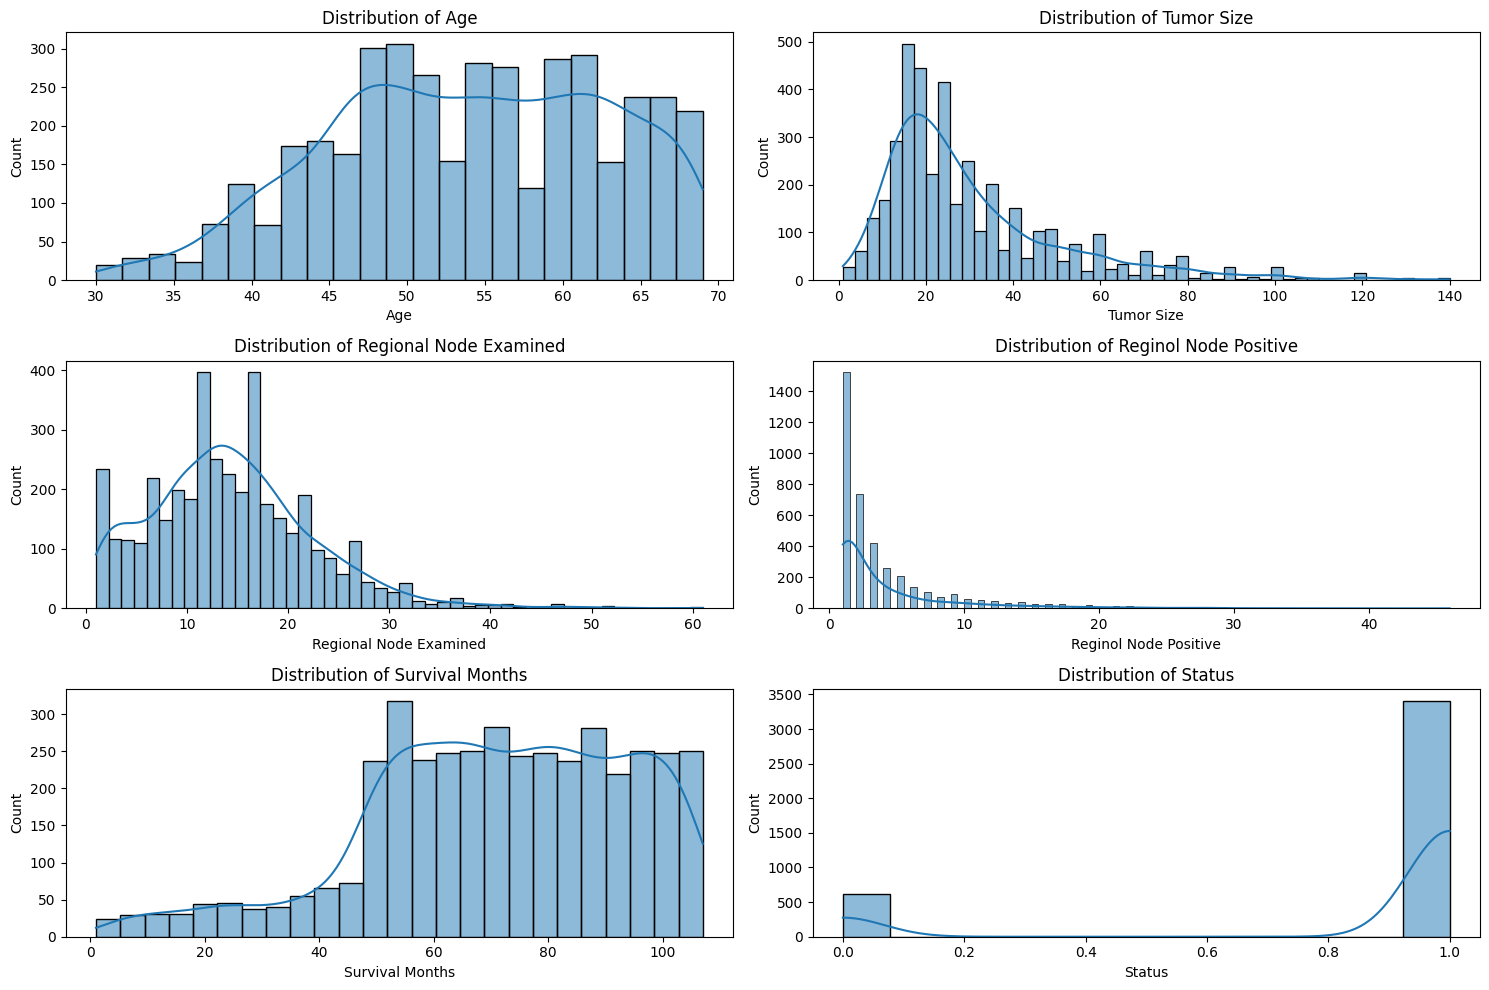

In [24]:
pplot.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    pplot.subplot(3, 2, i)
    pplot.title(f'Distribution of {col}')
    sns.histplot(df[col], kde=True)
    pplot.tight_layout()
    pplot.plot()

In [248]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn import set_config
set_config(transform_output="pandas")
X = df[num_cols + string_cols]
y = df['Status']

class ColumnExtractor(object):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_cols = X[self.columns]

        return X_cols

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('num_var', Pipeline([
            ('extract', ColumnExtractor(columns=num_cols)),
            ('poly', PolynomialFeatures(degree=2))
        ])),
        ('cat_var', Pipeline([
            ('extract', ColumnExtractor(columns=string_cols)),
#             ('le', LabelEncoder()),
            ('ohe', OneHotEncoder(sparse=False)),
        ]))
    ])),
    #('estimator', LogisticRegression())
])

X_preprocessed = pipeline.fit_transform(X)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [264]:
# oversample
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=11)

X_oversample, y_oversample = smote.fit_resample(X_preprocessed, y)
X_oversample = pd.DataFrame(X_oversample, columns=X_preprocessed.columns)


In [265]:
X_oversample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6816 entries, 0 to 6815
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   1                                             6816 non-null   float64
 1   age                                           6816 non-null   float64
 2   tumor_size                                    6816 non-null   float64
 3   regional_node_examined                        6816 non-null   float64
 4   reginol_node_positive                         6816 non-null   float64
 5   survival_months                               6816 non-null   float64
 6   age^2                                         6816 non-null   float64
 7   age tumor_size                                6816 non-null   float64
 8   age regional_node_examined                    6816 non-null   float64
 9   age reginol_node_positive                     6816 non-null   f

In [266]:
print(y.value_counts())
print(y_oversample.value_counts())

Status
1    3408
0     616
Name: count, dtype: int64
Status
1    3408
0    3408
Name: count, dtype: int64


In [267]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample, test_size=0.2, stratify=y_oversample, random_state=11)

In [269]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
models = {
#     'CatBoost': CatBoostClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'XGB': xgb.XGBClassifier(random_state=42),
    'LGBM': lgb.LGBMClassifier(verbosity=0, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # Train the model
    cross_validate(model, X_train, y_train, cv=cv)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'{model_name}: Accuracy = {accuracy:.4f}')

Random Forest: Accuracy = 0.9494


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/

Logistic Regression: Accuracy = 0.7933
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LGBM: Accuracy = 0.9545


In [270]:
import lightgbm as lgb
model = lgb.LGBMClassifier(verbosity=0, random_state=11)


In [271]:
model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


LGBMClassifier(random_state=11, verbosity=0)

In [273]:
#parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'n_estimators': [100, 200, 500],
    'boosting_type': ['gbdt', 'dart']
}

In [274]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in

In [275]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("Classification Report:\n", report)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       682
           1       0.95      0.97      0.96       682

    accuracy                           0.96      1364
   macro avg       0.96      0.96      0.96      1364
weighted avg       0.96      0.96      0.96      1364

Accuracy: 95.82%


In [272]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("Classification Report:\n", report)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       682
           1       0.94      0.98      0.96       682

    accuracy                           0.95      1364
   macro avg       0.96      0.95      0.95      1364
weighted avg       0.96      0.95      0.95      1364

Accuracy: 95.45%
